In [2]:
# 1. Imports & basic setup
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import glob
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

!unzip -o ecg-id-database-1.0.0.zip > /dev/null

general_directory = "/content/ecg-id-database-1.0.0"
entries = os.listdir(general_directory)

fs = 500

# 2. Load ECG, detect R-peaks, segment beats

subjects = []
ecg_beats = []

for folder in entries:
    if "Person_" not in folder:
        continue

    info_pattern = os.path.join(general_directory, folder, "*.hea")
    info_files = glob.glob(info_pattern)

    for ecg_info in info_files:
        try:
            subject_id = int(folder.replace("Person_", "", 1))

            ecg_signal_file = ecg_info.replace(".hea", ".dat")
            ecg_signal = np.fromfile(ecg_signal_file, dtype="int32").astype(np.float32)

            ecg_signal = ecg_signal / np.max(np.abs(ecg_signal))

            ts = np.arange(0, len(ecg_signal) / fs, 1 / fs)

            pks_RR = sp.signal.find_peaks(
                ecg_signal,
                height=np.mean(np.abs(ecg_signal) * 5),
                distance=500  # at least 1 second apart at 500 Hz
            )[0]

            if len(pks_RR) <= 1:
                continue

            for i in range(len(pks_RR) - 1):
                start, end = pks_RR[i], pks_RR[i + 1]
                beat = ecg_signal[start:end]

                if len(beat) < 50:
                    continue

                subjects.append(subject_id)
                ecg_beats.append(beat)

        except Exception as e:
            print(f"Error processing file {ecg_info}: {e}")

df = pd.DataFrame({
    "Subject": subjects,
    "ECG_Samples": ecg_beats
})

In [3]:
print("Number of beats extracted:", len(df))
df.head()

Number of beats extracted: 2832


,Subject,ECG_Samples
0,34,"[0.8755905, 0.8612361, 0.7990341, 0.69376904, ..."
1,34,"[0.91865414, 0.87080646, 0.78468055, 0.6746305..."
2,34,"[0.92822146, 0.91386724, 0.86123484, 0.7703251..."
3,34,"[0.947366, 0.904302, 0.82296056, 0.70334125, 0..."
4,34,"[1.0, 0.96172214, 0.87081176, 0.74162406, 0.59..."


In [4]:
df.tail()

,Subject,ECG_Samples
2827,28,"[0.8045121, 0.7744378, 0.69924915, 0.5939855, ..."
2828,28,"[1.0, 0.9398496, 0.8270666, 0.6616517, 0.46616..."
2829,28,"[0.8721796, 0.8646616, 0.8195513, 0.7368435, 0..."
2830,28,"[0.9473685, 0.9097746, 0.8195484, 0.6766913, 0..."
2831,28,"[0.8947382, 0.83458734, 0.7293229, 0.56390727,..."


In [5]:
df.shape

(2832, 2)

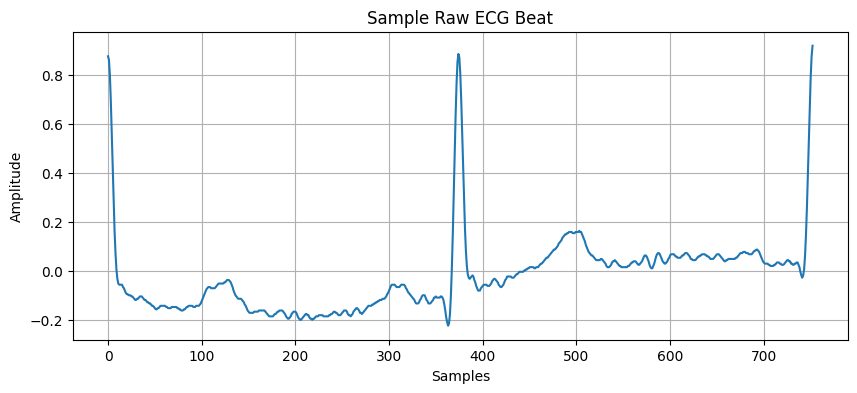

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(ecg_beats[0])
plt.title("Sample Raw ECG Beat")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

Max length: 6861
Mean length: 886
Final smoothed beat length: 872
Shape of ecg_samples_np: (2832, 872)


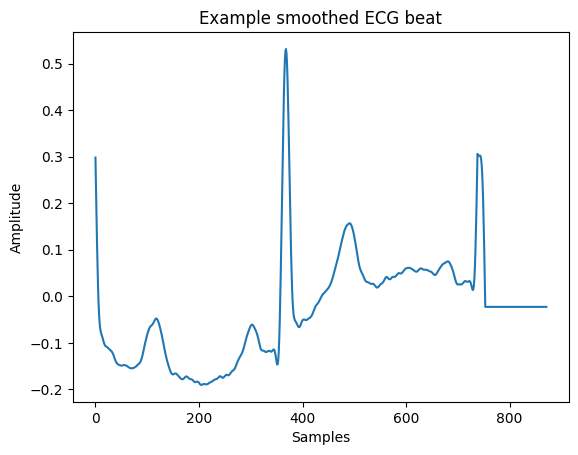

In [7]:
# 4. Fix length (pad/truncate) + smoothing

signal_lengths = [len(s) for s in df["ECG_Samples"].values]
max_length = max(signal_lengths)
mean_length = int(np.round(np.mean(signal_lengths)))

print("Max length:", max_length)
print("Mean length:", mean_length)

def pad_truncate_signal_mean(signal, target_length=mean_length):
    signal = np.asarray(signal, dtype=np.float32)
    signal_mean = np.mean(signal)

    if len(signal) > target_length:
        return signal[:target_length]
    elif len(signal) < target_length:
        pad_width = target_length - len(signal)
        return np.pad(signal, (0, pad_width), mode="constant", constant_values=signal_mean)
    else:
        return signal

def moving_average(signal, window_size=15):
    signal = np.asarray(signal, dtype=np.float32)
    return np.convolve(signal, np.ones(window_size) / window_size, mode="valid")

df["ECG_Padded"] = df["ECG_Samples"].apply(lambda x: pad_truncate_signal_mean(x, mean_length))
df["Smoothed_ECG"] = df["ECG_Padded"].apply(lambda x: moving_average(x, window_size=15))

input_dim = len(df["Smoothed_ECG"].iloc[0])
print("Final smoothed beat length:", input_dim)

ecg_samples_np = np.stack(df["Smoothed_ECG"].values).astype(np.float32)
print("Shape of ecg_samples_np:", ecg_samples_np.shape)

plt.plot(ecg_samples_np[0])
plt.title("Example smoothed ECG beat")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.5910 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1789 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0594 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - learning_rate: 0.0010
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - learning_rate: 0.0010
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 

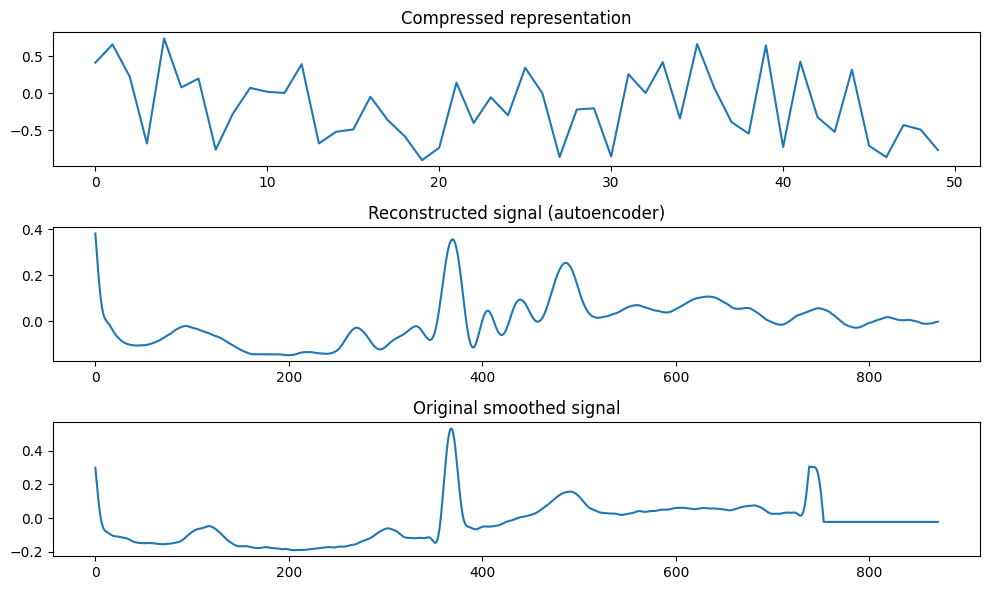

In [8]:
# 5. Autoencoder for compressed representation
encoding_dim = 50

input_signal = Input(shape=(input_dim,))

# Encoder
x = Dense(128, activation="tanh", kernel_initializer="glorot_uniform",
          kernel_regularizer=l2(0.001))(input_signal)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(256, activation="tanh", kernel_initializer="glorot_uniform",
          kernel_regularizer=l2(0.001))(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

encoded = Dense(encoding_dim, activation="tanh")(x)

# Decoder
y = Dense(128, activation="tanh", kernel_initializer="glorot_uniform",
          kernel_regularizer=l2(0.001))(encoded)
y = Dropout(0.2)(y)
y = BatchNormalization()(y)

y = Dense(256, activation="tanh", kernel_initializer="glorot_uniform",
          kernel_regularizer=l2(0.001))(y)
y = Dropout(0.2)(y)
y = BatchNormalization()(y)

decoded = Dense(input_dim, activation="tanh", kernel_initializer="glorot_uniform")(y)

autoencoder = Model(input_signal, decoded)

optimizer = Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5, min_lr=1e-5)

autoencoder.compile(optimizer=optimizer, loss="huber")
history = autoencoder.fit(
    ecg_samples_np, ecg_samples_np,
    epochs=100,
    batch_size=64,
    shuffle=True,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

encoder = Model(input_signal, encoded)
decoder = Model(encoded, decoded)

compressed_signals = encoder.predict(ecg_samples_np)
reconstructed_signals = decoder.predict(compressed_signals)

print("Compressed shape:", compressed_signals.shape)

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(compressed_signals[0])
plt.title("Compressed representation")

plt.subplot(3, 1, 2)
plt.plot(reconstructed_signals[0])
plt.title("Reconstructed signal (autoencoder)")

plt.subplot(3, 1, 3)
plt.plot(ecg_samples_np[0])
plt.title("Original smoothed signal")

plt.tight_layout()
plt.show()


In [9]:
# 6. Unconditional GAN on compressed signals
import keras
from keras import layers

decomposed_signals = compressed_signals.astype(np.float32)
signal_dim = decomposed_signals.shape[1]

batch_size = 64
latent_dim = 128

dataset = tf.data.Dataset.from_tensor_slices(decomposed_signals)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Generator
def build_generator(latent_dim, signal_dim):
    z = keras.Input(shape=(latent_dim,))
    x = layers.Dense(128)(z)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    out = layers.Dense(signal_dim, activation="tanh")(x)
    return keras.Model(z, out, name="generator")

# Discriminator
def build_discriminator(signal_dim):
    inp = keras.Input(shape=(signal_dim,))
    x = layers.Dense(256)(inp)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(0.2)(x)
    out = layers.Dense(1)(x)  # logit
    return keras.Model(inp, out, name="discriminator")

generator = build_generator(latent_dim, signal_dim)
discriminator = build_discriminator(signal_dim)

generator.summary()
discriminator.summary()

class SimpleGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

        self.gen_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_signals):
        batch_size = tf.shape(real_signals)[0]

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_signals = self.generator(random_latent_vectors)

        combined_signals = tf.concat([real_signals, generated_signals], axis=0)
        labels = tf.concat([
            tf.ones((batch_size, 1)),   # real
            tf.zeros((batch_size, 1))   # fake
        ], axis=0)

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_signals)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_signals = self.generator(random_latent_vectors)
            predictions = self.discriminator(fake_signals)
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {"g_loss": self.gen_loss_tracker.result(),
                "d_loss": self.disc_loss_tracker.result()}

gan = SimpleGAN(generator=generator, discriminator=discriminator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,386 (243.70 KB)

 Trainable params: 62,386 (243.70 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,081 (180.00 KB)

 Trainable params: 46,081 (180.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150 - g_loss: 0.9209, d_loss: 0.4795
Epoch 2/150 - g_loss: 0.8626, d_loss: 0.6247
Epoch 3/150 - g_loss: 1.0823, d_loss: 0.5910
Epoch 4/150 - g_loss: 1.3730, d_loss: 0.5386
Epoch 5/150 - g_loss: 1.6323, d_loss: 0.4746
Epoch 6/150 - g_loss: 2.1004, d_loss: 0.3617
Epoch 7/150 - g_loss: 1.9250, d_loss: 0.4400
Epoch 8/150 - g_loss: 2.6333, d_loss: 0.2493
Epoch 9/150 - g_loss: 2.5466, d_loss: 0.2948
Epoch 10/150 - g_loss: 2.8546, d_loss: 0.2490
Epoch 11/150 - g_loss: 2.7030, d_loss: 0.2189
Epoch 12/150 - g_loss: 2.4388, d_loss: 0.2752
Epoch 13/150 - g_loss: 2.5629, d_loss: 0.2074
Epoch 14/150 - g_loss: 2.5535, d_loss: 0.2186
Epoch 15/150 - g_loss: 2.5450, d_loss: 0.2098
Epoch 16/150 - g_loss: 2.4743, d_loss: 0.2367
Epoch 17/150 - g_loss: 2.6552, d_loss: 0.2068
Epoch 18/150 - g_loss: 2.6645, d_loss: 0.1764
Epoch 19/150 - g_loss: 2.9256, d_loss: 0.1662
Epoch 20/150 - g_loss: 3.0572, d_loss: 0.1337
Epoch 21/150 - g_loss: 2.6091, d_loss: 0.1685
Epoch 22/150 - g_loss: 2.8734, d_loss: 0.12

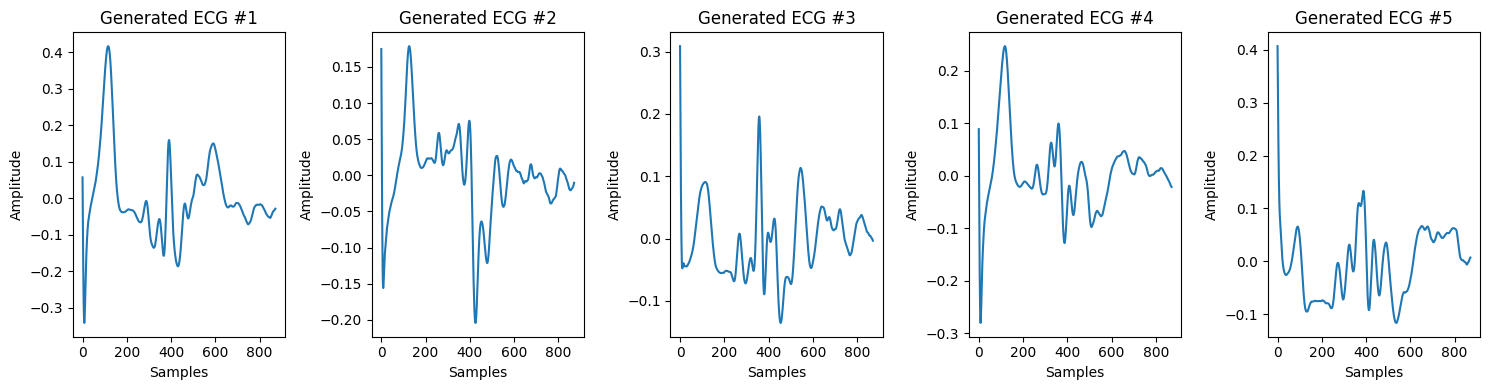

Epoch 51/150 - g_loss: 3.1983, d_loss: 0.0902
Epoch 52/150 - g_loss: 3.2756, d_loss: 0.1057
Epoch 53/150 - g_loss: 3.3333, d_loss: 0.0990
Epoch 54/150 - g_loss: 3.4078, d_loss: 0.1070
Epoch 55/150 - g_loss: 3.2949, d_loss: 0.1030
Epoch 56/150 - g_loss: 3.2842, d_loss: 0.0964
Epoch 57/150 - g_loss: 3.3141, d_loss: 0.1101
Epoch 58/150 - g_loss: 3.2733, d_loss: 0.1055
Epoch 59/150 - g_loss: 3.3164, d_loss: 0.1006
Epoch 60/150 - g_loss: 3.3861, d_loss: 0.1151
Epoch 61/150 - g_loss: 3.3600, d_loss: 0.1120
Epoch 62/150 - g_loss: 3.3854, d_loss: 0.1067
Epoch 63/150 - g_loss: 3.3650, d_loss: 0.1069
Epoch 64/150 - g_loss: 3.4566, d_loss: 0.1142
Epoch 65/150 - g_loss: 3.4392, d_loss: 0.1217
Epoch 66/150 - g_loss: 3.3917, d_loss: 0.1114
Epoch 67/150 - g_loss: 3.4130, d_loss: 0.1144
Epoch 68/150 - g_loss: 3.6420, d_loss: 0.1153
Epoch 69/150 - g_loss: 3.4474, d_loss: 0.1159
Epoch 70/150 - g_loss: 3.3972, d_loss: 0.1167
Epoch 71/150 - g_loss: 3.4588, d_loss: 0.1202
Epoch 72/150 - g_loss: 3.5538, d_l

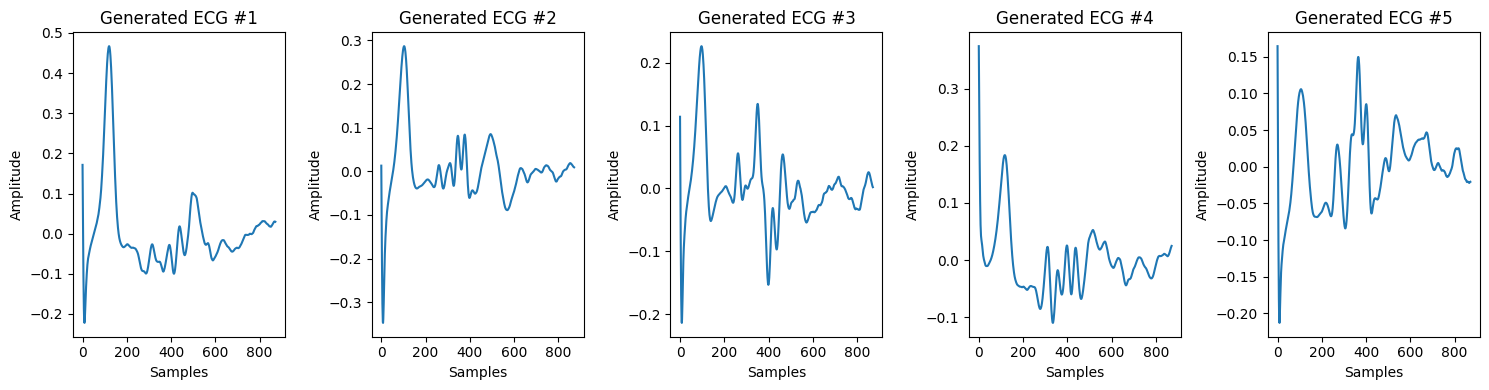

Epoch 101/150 - g_loss: 3.2516, d_loss: 0.1351
Epoch 102/150 - g_loss: 3.3818, d_loss: 0.1391
Epoch 103/150 - g_loss: 3.2390, d_loss: 0.1354
Epoch 104/150 - g_loss: 3.2131, d_loss: 0.1355
Epoch 105/150 - g_loss: 3.3082, d_loss: 0.1423
Epoch 106/150 - g_loss: 3.4430, d_loss: 0.1601
Epoch 107/150 - g_loss: 3.3129, d_loss: 0.1481
Epoch 108/150 - g_loss: 3.2983, d_loss: 0.1472
Epoch 109/150 - g_loss: 3.2817, d_loss: 0.1420
Epoch 110/150 - g_loss: 3.2225, d_loss: 0.1450
Epoch 111/150 - g_loss: 3.1871, d_loss: 0.1495
Epoch 112/150 - g_loss: 3.3254, d_loss: 0.1451
Epoch 113/150 - g_loss: 3.3982, d_loss: 0.1501
Epoch 114/150 - g_loss: 3.2780, d_loss: 0.1502
Epoch 115/150 - g_loss: 3.2610, d_loss: 0.1435
Epoch 116/150 - g_loss: 3.3438, d_loss: 0.1623
Epoch 117/150 - g_loss: 3.4061, d_loss: 0.1516
Epoch 118/150 - g_loss: 3.4604, d_loss: 0.1587
Epoch 119/150 - g_loss: 3.3427, d_loss: 0.1651
Epoch 120/150 - g_loss: 3.4042, d_loss: 0.1586
Epoch 121/150 - g_loss: 3.4076, d_loss: 0.1629
Epoch 122/150

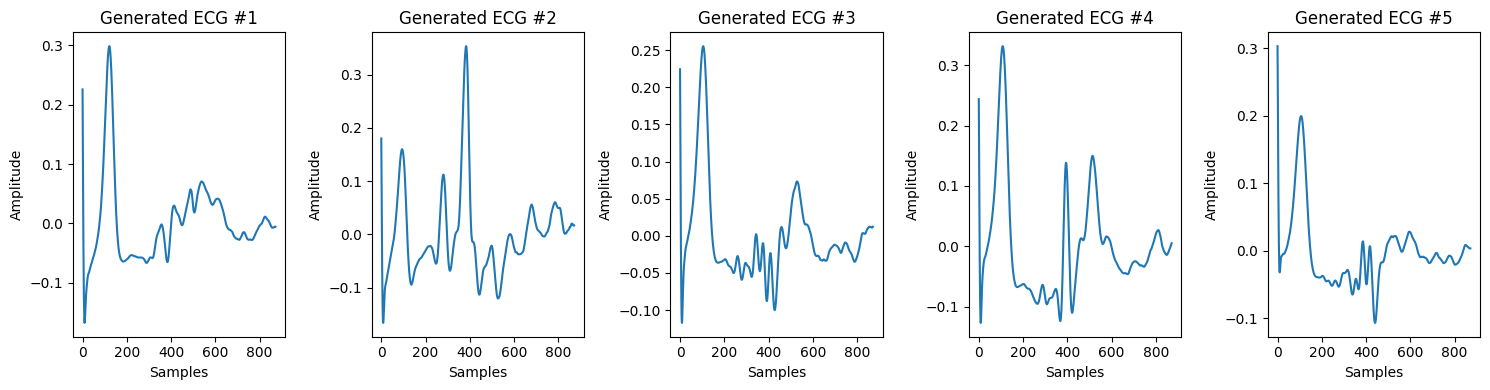

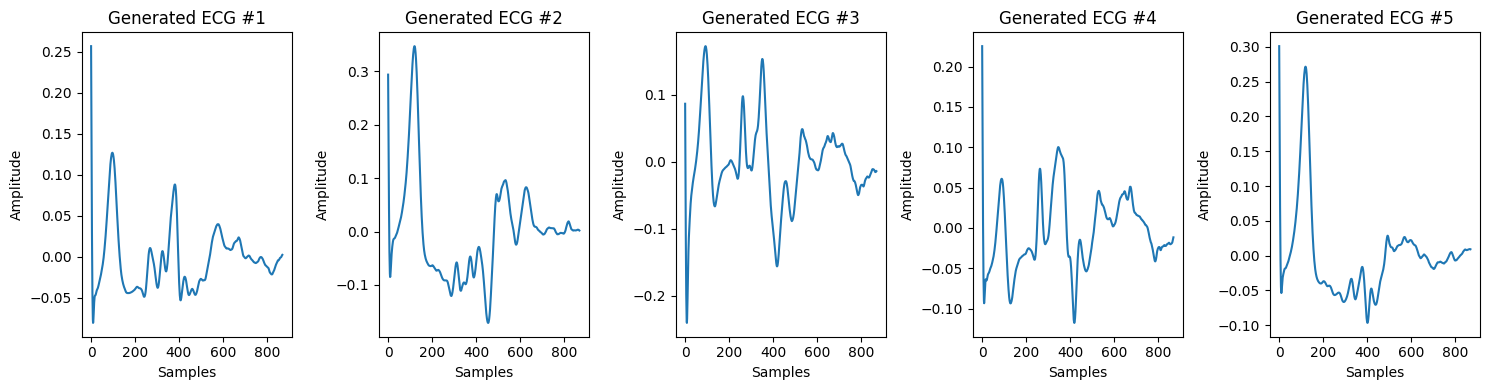

In [10]:
# 7. Training loop + visualization
def generate_and_plot_ecg(num_samples=3):
    """Sample from GAN, decode with autoencoder decoder, plot ECG beats."""
    random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
    generated_compressed = generator.predict(random_latent_vectors, verbose=0)
    generated_ecg = decoder.predict(generated_compressed, verbose=0)

    plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.plot(generated_ecg[i])
        plt.title(f"Generated ECG #{i+1}")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

epochs = 150
for epoch in range(epochs):
    history = gan.fit(dataset, epochs=1, verbose=0)

    g_loss = history.history["g_loss"][-1]
    d_loss = history.history["d_loss"][-1]

    print(f"Epoch {epoch + 1}/{epochs} - g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}")
    if (epoch + 1) % 50 == 0:
        print(f"--- Visualization at epoch {epoch + 1} ---")
        generate_and_plot_ecg(num_samples=5)

generate_and_plot_ecg(num_samples=5)


In [11]:
# Generate synthetic ECG dataset
num_fake = ecg_samples_np.shape[0]

z_fake = tf.random.normal(shape=(num_fake, latent_dim))

compressed_fake = generator.predict(z_fake, verbose=0)

fake_ecg = decoder.predict(compressed_fake, verbose=0)

print("Real dataset shape :", ecg_samples_np.shape)
print("Fake ECG dataset shape:", fake_ecg.shape)

Real dataset shape : (2832, 872)
Fake ECG dataset shape: (2832, 872)


RMSE (mean real vs mean fake waveform): 0.026477702428696247


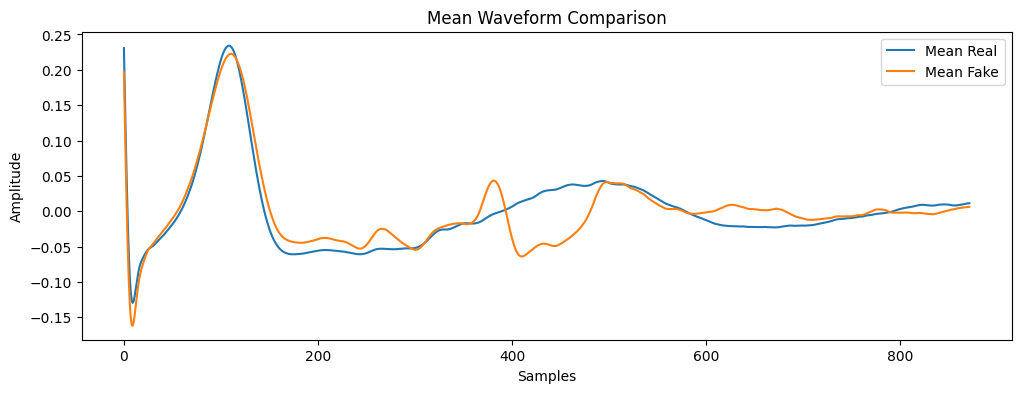

In [12]:
# RMSE between average waveforms
from sklearn.metrics import mean_squared_error
import numpy as np

mean_real = np.mean(ecg_samples_np, axis=0)
mean_fake = np.mean(fake_ecg, axis=0)

rmse_mean_waveform = np.sqrt(mean_squared_error(mean_real, mean_fake))
print("RMSE (mean real vs mean fake waveform):", rmse_mean_waveform)

plt.figure(figsize=(12,4))
plt.plot(mean_real, label="Mean Real")
plt.plot(mean_fake, label="Mean Fake")
plt.title("Mean Waveform Comparison")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error

def extract_features(signals):
    signals = np.asarray(signals)

    means = np.mean(signals, axis=1)
    variances = np.var(signals, axis=1)
    max_vals = np.max(signals, axis=1)
    min_vals = np.min(signals, axis=1)
    ptp_vals = max_vals - min_vals
    rms = np.sqrt(np.mean(signals**2, axis=1))

    return np.stack([means, variances, ptp_vals, rms], axis=1)

real_features = extract_features(ecg_samples_np)
fake_features = extract_features(fake_ecg)

feature_rmse = np.sqrt(
    mean_squared_error(
        np.mean(real_features, axis=0),
        np.mean(fake_features, axis=0)
    )
)

print("RMSE (feature-level):", feature_rmse)


RMSE (feature-level): 0.13834211604788701


In [14]:
!pip install -q gradio

import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def smooth_for_display(signal, window_size=15):
    signal = np.asarray(signal, dtype=np.float32)
    kernel = np.ones(window_size) / window_size
    return np.convolve(signal, kernel, mode="same")

def generate_fake_ecg(num_samples: int, seed: int):
    num_samples = int(num_samples)
    seed = int(seed)
    tf.random.set_seed(seed)
    z_fake = tf.random.normal(shape=(num_samples, latent_dim))
    compressed_fake = generator.predict(z_fake, verbose=0)
    fake_ecg_raw = decoder.predict(compressed_fake, verbose=0)
    fake_ecg = np.array([smooth_for_display(sig) for sig in fake_ecg_raw])
    fig, axes = plt.subplots(num_samples, 1, figsize=(8, 2 * num_samples), sharex=True)
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        axes[i].plot(fake_ecg[i])
        axes[i].set_ylabel("Amp")
        axes[i].set_title(f"Fake ECG #{i+1}")

    axes[-1].set_xlabel("Samples")
    plt.tight_layout()

    return fig

# Gradio UI
demo = gr.Interface(
    fn=generate_fake_ecg,
    inputs=[
        gr.Slider(1, 10, value=3, step=1, label="Number of ECG samples"),
        gr.Slider(0, 500, value=0, step=1, label="Random seed"),
    ],
    outputs=gr.Plot(label="Generated ECG signals"),
    title="ECG-GAN: Synthetic ECG Generator",
    description="Choose how many fake ECG beats to generate, then hit Submit.",
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a3e43b5d12d507d976.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [22]:
!pip install -q gradio

import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def generate_fake_ecg(num_samples: int, seed: int):
    num_samples = int(num_samples)
    seed = int(seed)

    tf.random.set_seed(seed)

    z_fake = tf.random.normal(shape=(num_samples, latent_dim))

    compressed_fake = generator.predict(z_fake, verbose=0)

    fake_ecg = decoder.predict(compressed_fake, verbose=0)

    fig, axes = plt.subplots(num_samples, 1, figsize=(8, 2 * num_samples), sharex=True)
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        axes[i].plot(fake_ecg[i])
        axes[i].set_ylabel("Amp")
        axes[i].set_title(f"Fake ECG #{i+1}")

    axes[-1].set_xlabel("Samples")
    plt.tight_layout()

    return fig

# Gradio UI
demo = gr.Interface(
    fn=generate_fake_ecg,
    inputs=[
        gr.Slider(1, 10, value=3, step=1, label="Number of ECG samples"),
        gr.Slider(0, 500, value=0, step=1, label="Random seed"),
    ],
    outputs=gr.Plot(label="Generated ECG signals"),
    title="ECG-GAN: Synthetic ECG Generator",
    description="Choose how many fake ECG beats to generate, then hit Submit.",
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1b5ef7b1fc6824e1f0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
